In [1]:
import torch

import glob
import mmcv
import numpy as np
from mmdet.structures import DetDataSample

import albumentations as A
from albumentations.pytorch import ToTensorV2

from utils import (
    vision,
    modules,
    custom_dataset, 
)

# Parameters

In [2]:
IMG_PREFIX = "data/test2/"
config = "config.py"
pth = "work_dir/RTMDet_model.pt"

In [3]:
class CustomDatset(torch.utils.data.Dataset):
    after_transform = A.Compose(
        [
            A.Normalize(),
            ToTensorV2()
        ],
    )
    
    hor = A.Compose([A.HorizontalFlip(p=1.)])
    ver = A.Compose([A.VerticalFlip(p=1.)])
    
    def __init__(
        self,
        img_prefix="data/test1/",
        fill_pad_factor=32,
        fill_pad_value=255
    ):
        """ 自定义加载数据集
        
        Args:
            img_prefix (str): 图片的根目录
            fill_pad_factor (int): 将宽高填充至倍数
            fill_pad_value (int): 填充值
        """
        self.images = sorted(glob.glob(f"{img_prefix}/*.jpg"))
        
        self.fill_pad_factor = fill_pad_factor
        self.fill_pad_value = fill_pad_value
        self.len = len(self.images)
        
        self.type = None
        
    def __getitem__(self, idx):
        img = self.images[idx]
        x = mmcv.imread(img, channel_order="rgb")
        inputs, data_sample = self.pipeline(x)
        
        return inputs, data_sample
    
    def pipeline(self, img, image_id=None):
        org_h, org_w, _ = img.shape
        h, w, c = img.shape
        scale_factor = (1., 1.)
        flip = False
        flip_direction = "y"
        if self.type == "hor":
            item = self.hor(image=img)
            img = item["image"]
        elif self.type == "ver":
            item = self.ver(image=img)
            img = item["image"]
        elif self.type is None:
            ...
        elif isinstance(self.type, float):
            new_h, new_w = int(h * self.type), int(w * self.type)
            item = A.Resize(new_h, new_w)(image=img)
            img = item["image"]
            new_h, new_w, c = img.shape
            scale_factor = (new_w / w, new_h / h)
            h, w = new_h, new_w
        elif self.type == 90:
            img = np.rot90(img, 1, (0, 1))
            h, w, c = img.shape
        else:
            raise ValueError(f"不能解释的类型：{self.type}")

        pad_h = h
        pad_w = w
        if (
            h % self.fill_pad_factor != 0 or
            w % self.fill_pad_factor != 0
        ):
            if h % self.fill_pad_factor != 0:
                pad_h = (h // self.fill_pad_factor + 1) * self.fill_pad_factor
                
            if w % self.fill_pad_factor != 0:
                pad_w = (w // self.fill_pad_factor + 1) * self.fill_pad_factor
             
            pad_img = np.full((pad_h, pad_w, c), self.fill_pad_value, dtype=img.dtype)
            pad_img[:h, :w] = img
            img = pad_img
        
        item = self.after_transform(image=img)
        img = item["image"]
        
        data_sample = DetDataSample()
        img_meta = dict(
            org_shape=(org_h, org_w),
            img_shape=(h, w),
            pad_shape=(pad_h, pad_w),
            scale_factor=scale_factor,
            image_id=image_id,
            keep_ratio=True,
            flip=flip,
            flip_direction=flip_direction,
        )

        data_sample.set_metainfo(img_meta)

        return img, data_sample
        
    def __len__(self):
        return self.len

In [4]:
model = modules.Model(config)
model.load_state_dict(torch.load(pth, "cpu")["model"])
model.eval();

All Keys Matching


In [5]:
valid_dataloader = torch.utils.data.DataLoader(
    CustomDatset(IMG_PREFIX),
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=custom_dataset.collate_fn,
)

# Vision Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


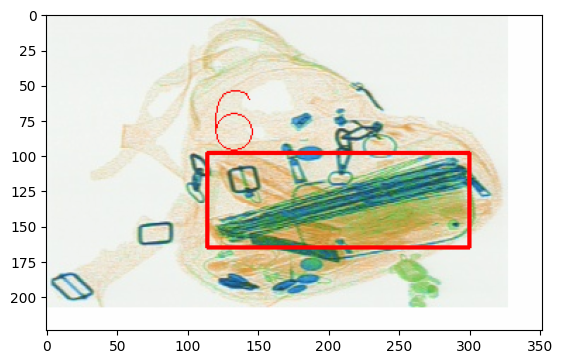

In [22]:
batch = next(iter(valid_dataloader))
output = model(batch, "predict")
vision.vision_infer(batch, output, .6)